In [1]:
#All packages
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
data=pd.read_csv('customer_churn.csv')

In [3]:
# replace blanks with np.nan
data['TotalCharges']=data['TotalCharges'].replace(' ', np.nan)
# convert to float64
data['TotalCharges']=data['TotalCharges'].astype('float64')

In [4]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [5]:
#These plots are total charges against tenure
#Most of the month to month contract customers tend to churn (more than one year/two year contracts)
#Also, as the tenure increases, so does the total charges.
#Its not a full correlation but the likelihood is high customer tenure have high charges.

import plotly.express as px

fig = px.scatter(x=data['tenure'], y=data['TotalCharges'], 
                 color = data['Churn'], template = 'presentation', 
                 opacity = 0.5, facet_col = data['Contract'], 
                 title = 'Customer Churn by Tenure, Charges, and Contract Type',
                 labels = {'x' : 'Customer Tenure', 'y' : 'Total Charges $'})
                
fig.show()

In [6]:
#There are 11 missing TotalCharges, however because we are using Pycaret we can impute it automatically.
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [7]:
import pycaret
pycaret.__version__

'2.2.0'

In [8]:
#Pycaret is a low-code solution so we can use less data preparation steps
from pycaret.classification import *
s = setup(data, target = 'Churn', fold_shuffle=True, ignore_features = ['customerID'])

,Description,Value
0,session_id,6970
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(7043, 21)"
5,Missing Values,True
6,Numeric Features,3
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [9]:
# compare all models
best_model = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8047,0.8464,0.5124,0.6663,0.5784,0.4542,0.4614,0.0900
ada,Ada Boost Classifier,0.8012,0.8449,0.5147,0.6537,0.5753,0.4480,0.4539,0.0390
lr,Logistic Regression,0.8069,0.8431,0.5558,0.6545,0.6008,0.4746,0.4776,0.9100
catboost,CatBoost Classifier,0.7990,0.8389,0.5070,0.6496,0.5685,0.4403,0.4466,0.9960
lda,Linear Discriminant Analysis,0.7996,0.8354,0.5535,0.6336,0.5905,0.4588,0.4608,0.0100
lightgbm,Light Gradient Boosting Machine,0.7947,0.8348,0.5085,0.6351,0.5639,0.4320,0.4371,0.0240
nb,Naive Bayes,0.7383,0.8286,0.7953,0.5004,0.6141,0.4314,0.4581,0.0060
xgboost,Extreme Gradient Boosting,0.7830,0.8210,0.5008,0.6027,0.5464,0.4056,0.4089,0.1050
rf,Random Forest Classifier,0.7862,0.8186,0.4822,0.6188,0.5409,0.4046,0.4106,0.0980
et,Extra Trees Classifier,0.7702,0.7863,0.4643,0.5758,0.5137,0.3656,0.3695,0.0990


In [10]:
# print best_model parameters
print(best_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=6970, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [11]:
# tune best model
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8053,0.8564,0.5116,0.6667,0.5789,0.4551,0.4619
1,0.8256,0.8584,0.5581,0.7129,0.6261,0.5145,0.5211
2,0.8093,0.8416,0.5504,0.6636,0.6017,0.4778,0.4814
3,0.7890,0.8371,0.4729,0.6289,0.5398,0.4065,0.4135
4,0.8195,0.8520,0.5349,0.7041,0.6079,0.4935,0.5014
5,0.8195,0.8837,0.5194,0.7128,0.6009,0.4879,0.4981
6,0.8174,0.8413,0.5426,0.6931,0.6087,0.4919,0.4982
7,0.7972,0.8637,0.4419,0.6706,0.5327,0.4101,0.4246
8,0.7809,0.8253,0.5194,0.5929,0.5537,0.4094,0.4110
9,0.7890,0.8255,0.4651,0.6316,0.5357,0.4033,0.4112


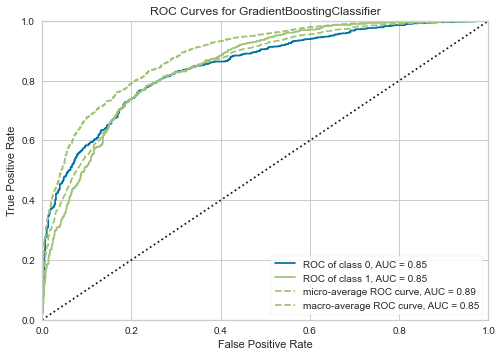

In [12]:
# AUC Plot
plot_model(tuned_best_model, plot = 'auc')

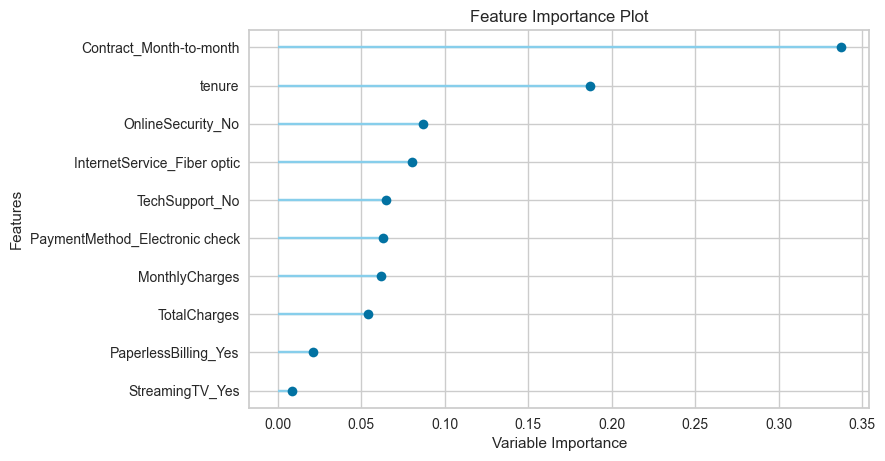

In [14]:
# Feature Importance Plot
plot_model(tuned_best_model, plot = 'feature')

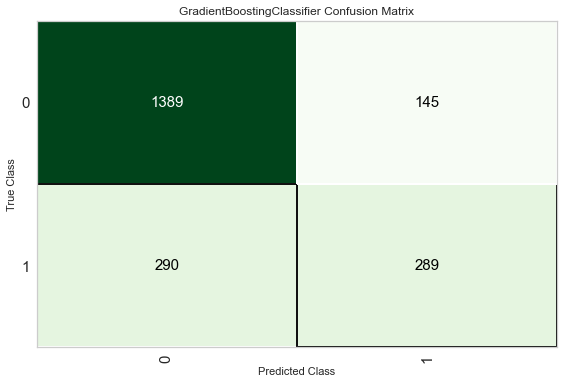

In [15]:
# Confusion Matrix
#Top left are the customers that will stay and we don't have to worry about
#Bottom right are the true positives customers that our model predicts will churn
#Top right, these are false positives, so we will suspect that they will churn, however they wont
#Bottom left, these are false negatives, so we predicted them to stay, however in reality they didnt.
plot_model(tuned_best_model, plot = 'confusion_matrix')

In [17]:
#The table at the top shows which model was used, the accuracy, the AUC ()
#This is the output table we want to send to the client, essentially their data back to them with the ID attached showing the Churn Label and Score.

predict_model(tuned_best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7941,0.8468,0.4991,0.6659,0.5706,0.4388,0.4467


,tenure,MonthlyCharges,TotalCharges,gender_Female,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn,Label,Score
0,1.0,50.750000,50.750000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,No,Yes,0.5455
1,49.0,20.150000,973.349976,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,No,No,0.9797
2,10.0,46.000000,492.100006,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,No,0.8012
3,46.0,94.650002,4312.500000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,No,No,0.8014
4,9.0,72.900002,651.400024,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,Yes,No,0.8040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108,36.0,91.949997,3301.050049,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,No,No,0.5741
2109,55.0,19.150000,998.099976,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,No,No,0.9698
2110,14.0,18.799999,255.550003,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,No,No,0.9784
2111,1.0,19.650000,19.650000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,No,No,0.7138


In [18]:
#Here is the complete data with the churn prediction score, the lower the score the more likely they are to churn
#We can then tidy this up for the client.
predictions = predict_model(tuned_best_model, data=data)
predictions.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Label,Score
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Yes,0.6674
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.50,No,No,0.9563
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,No,0.7019
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,No,0.9516
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Yes,0.6307
